## Import Starfish and other necessary libraries

In [2]:
%load_ext autoreload
%autoreload 2

import functools
import os
from typing import Mapping, Tuple, Union, Optional
import click
import numpy as np
from skimage.io import imread
from slicedimage import ImageFormat
from slicedimage.backends import CachingBackend, DiskBackend, HttpBackend, SIZE_LIMIT
import pdb
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt

import starfish
from starfish import Codebook, ImageStack, Experiment, ImageStack
from starfish.experiment.builder import FetchedTile, TileFetcher, write_experiment_json
from starfish.types import Axes, Coordinates, CoordinateValue, Features
from starfish.image import Filter, LearnTransform, ApplyTransform
from starfish.core.image._registration.transforms_list import TransformsList
from starfish.util.plot import (
    diagnose_registration, imshow_plane, intensity_histogram
)


## Export data to SpaceTX format

First create the subclasses of `FetchedTile` and `TileFetcher` required and then export the data into SpaceTX

In [2]:
@functools.lru_cache(maxsize=1)
def cached_read_fn(file_path) -> np.ndarray:
    return imread(file_path)

class StarMapTile(FetchedTile):

    def __init__(
            self,
            file_path: str,
            coordinates: Mapping[Union[str, Coordinates], CoordinateValue]
    ) -> None:
        self.file_path = file_path
        self._coordinates = coordinates

    @property
    def shape(self) -> Mapping[Axes, int]:
        shape = np.shape(self.tile_data())
        return {Axes.Y: shape[1], Axes.X: shape[0]}

    @property
    def coordinates(self) -> Mapping[Union[str, Coordinates], CoordinateValue]:
        return self._coordinates
    
    def tile_data(self) -> np.ndarray:
        return imread(self.file_path)
    
    def __str__(self) -> str:
        return self.file_path
    
class StarMapTileFetcher(TileFetcher):
    
    def __init__(self, input_dir: str) -> None:
        self.input_dir = input_dir
        
    def get_tile(
            self, fov_id: int, round_label: int, ch_label: int, zplane_label: int) -> FetchedTile:
        if zplane_label < 10:
            zplane_padded = f"00{zplane_label}"
        elif zplane_label < 100:
            zplane_padded = f"0{zplane_label}"
        else:
            zplane_padded = str(zplane_label)
        basename = f"Round{round_label+1}/Section3/starmap_5sections_C{ch_label}.tif"  # translate to 3d
        file_path = os.path.join(self.input_dir, basename)
        coordinates = {
            Coordinates.X: (0.0, 0.0001),
            Coordinates.Y: (0.0, 0.0001),
            Coordinates.Z: (0.0, 0.0001),
        }
        return StarMapTile(file_path, coordinates)
    
class StarMapNisslTileFetcher(TileFetcher):
    
    def __init__(self, input_dir: str) -> None:
        self.input_dir = input_dir
        
    def get_tile(
            self, fov_id: int, round_label: int, ch_label: int, zplane_label: int) -> FetchedTile:
        if zplane_label < 10:
            zplane_padded = f"00{zplane_label}"
        elif zplane_label < 100:
            zplane_padded = f"0{zplane_label}"
        else:
            zplane_padded = str(zplane_label)
        basename = f"Nissl/Section3/starmap_5sections_C{ch_label}.tif"
        file_path = os.path.join(self.input_dir, basename)
        coordinates = {
            Coordinates.X: (0.0, 0.0001),
            Coordinates.Y: (0.0, 0.0001),
            Coordinates.Z: (0.0, 0.0001),
        }
        return StarMapTile(file_path, coordinates)
    
def format_data(input_dir, output_dir):
    
    primary_image_dimensions: Mapping[Axes, int] = {
        Axes.ROUND: 6,
        Axes.CH: 5,
        Axes.ZPLANE: 1
    }
    
    aux_image_dimensions: Mapping[str, Mapping[Union[str, Axes], int]] = {
        "nissl": {
            Axes.ROUND: 1,
            Axes.CH: 2,
            Axes.ZPLANE: 1
        }
    }
    
    write_experiment_json(
        path=output_dir,
        fov_count=1,
        tile_format=ImageFormat.TIFF,
        primary_image_dimensions=primary_image_dimensions,
        aux_name_to_dimensions=aux_image_dimensions,
        primary_tile_fetcher=StarMapTileFetcher(input_dir),
        aux_tile_fetcher={"nissl": StarMapNisslTileFetcher(input_dir)},
        dimension_order=(Axes.ROUND, Axes.CH, Axes.ZPLANE)
    )
    
    codebook = [
        {
            Features.CODEWORD: [
                {Axes.ROUND.value: r, Axes.CH.value: c, Features.CODE_VALUE: 1}
            ],
            Features.TARGET: f"R{r}C{c}"
        } for r in range(6) for c in range(4)
    ]
        
        
    Codebook.from_code_array(codebook).to_json("/home/nomi/Desktop/starfish/experiment/codebook.json")

In [3]:
format_data("/home/nomi/Desktop/starfish/raw_data/AsTiff",
           "/home/nomi/Desktop/starfish/experiment")

/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: <_io.BytesIO object at 0x7fdd44382ad0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: <_io.BytesIO object at 0x7fdd443e1c50> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: <_io.BytesIO object at 0x7fdd44350cb0> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: <_io.BytesIO object at 0x7fdd44360110> is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: <_io.BytesIO object at 0x7fdd44382b30> is a low contrast image
  warn('%s is a

## Load the experiment and visualize the codebook
Possibly necessary to copy the codebook information from `codebook_backup.json`.

In [3]:
baseurl: str="/home/nomi/Desktop/starfish/experiment/experiment.json"
experiment = Experiment.from_json(baseurl)
experiment.codebook

<xarray.Codebook (target: 24, c: 4, r: 6)>
array([[[1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [1, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 1]]], dtype=uint8)
Coordinates:
  * target   (target) object 'R0C0' 'R0C1' 'R0C2' ... 'R5C1' 'R5C2' 'R5C3'
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3 4 5

## Extract FOV/primary images, and project onto the Z axis

In [4]:
fov: ImageStack = experiment["fov_000"]
primary: ImageStack = fov.get_image("primary")
nissl: ImageStack = fov.get_image("nissl")

/home/nomi/Desktop/starfish/.venv/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (115075067 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


## Register rounds against DAPI stain

In [ ]:
learnTranslation: LearnTransform.Translation = LearnTransform.Translation(
    reference_stack=nissl.sel({Axes.CH: 0, 
#                                Axes.X: (0, 3000), Axes.Y: (0, 6000)
                              }),
    axes=Axes.ROUND,
    upsampling=1
)
primaryTransforms: TransformsList = learnTranslation.run(primary.sel({Axes.CH: 0, 
#                                                                Axes.X: (0, 3000), Axes.Y: (0, 6000)
                                                              }))
# primaryRegistered: ImageStack = ApplyTransform.Warp().run(primary, transforms, in_place=False, verbose=True)

In [ ]:
learnTranslation: LearnTransform.Translation = LearnTransform.Translation(
    reference_stack=primary.sel({Axes.CH: 0, Axes.ROUND: 3, Axes.X: (0, 3000), Axes.Y: (0, 5000)}),
    axes=Axes.ROUND,
    upsampling=100
)
primaryTransforms: TransformsList = learnTranslation.run(primary.sel({Axes.CH: 0, Axes.X: (0, 3000), Axes.Y: (0, 5000)}))
nisslTransforms  : TransformsList = learnTranslation.run(nissl.sel({Axes.CH: 0, Axes.X: (0, 3000), Axes.Y: (0, 5000)}))

In [ ]:
os.remove("/home/nomi/Desktop/starfish/experiment/pRegistrations.json")
os.remove("/home/nomi/Desktop/starfish/experiment/nRegistrations.json")
primaryTransforms.to_json("/home/nomi/Desktop/starfish/experiment/pRegistrations.json")
nisslTransforms.to_json("/home/nomi/Desktop/starfish/experiment/nRegistrations.json")

In [5]:
primaryTransforms = TransformsList.from_json("/home/nomi/Desktop/starfish/experiment/pRegistrations.json")
# nisslTransforms = TransformsList.from_json("/home/nomi/Desktop/starfish/experiment/nRegistrations.json")

In [6]:
print([t[2].translation for t in primaryTransforms.transforms])
# print([t[2].translation for t in nisslTransforms.transforms])

[array([660., 425.]), array([1659.,  215.]), array([1660.,  215.]), array([825., 377.]), array([715., 675.]), array([769., 373.])]


In [7]:
primaryRegistered: ImageStack = ApplyTransform.Warp().run(primary, primaryTransforms, in_place=False, verbose=True)
# nisslRegistered  : ImageStack = ApplyTransform.Warp().run(nissl, nisslTransforms, in_place=False, verbose=True)

100%|██████████| 30/30 [00:24<00:00,  2.77it/s]


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


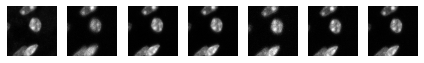

In [8]:
%gui qt
f, axes = plt.subplots(ncols=7)
imshow_plane(nissl, ax=axes[0], sel={Axes.CH: 0, 
                                               Axes.X: (1600, 1700), Axes.Y: (470,570)
                                              })
for i in range(6):
    imshow_plane(primaryRegistered, ax=axes[i+1], sel={Axes.CH: 0, Axes.ROUND: i, 
                                                       Axes.X: (1600, 1700), Axes.Y: (470,570)
                                                      })
f.tight_layout()

In [ ]:
%gui qt
f, axes = plt.subplot s(ncols=7)
imshow_plane(nissl, ax=axes[0], sel={Axes.CH: 0, 
                                               Axes.X: (1600, 1700), Axes.Y: (470,570)
                                              })
for i in range(6):
    imshow_plane(primaryRegistered, ax=axes[i+1], sel={Axes.CH: 0, Axes.ROUND: i, 
                                                       Axes.X: (1600, 1700), Axes.Y: (470,570)
                                                      })
f.tight_layout()

In [ ]:
%gui qt
f, axes = plt.subplots(ncols=7)
imshow_plane(nissl, ax=axes[0], sel={Axes.CH: 0, 
                                               Axes.X: (1600, 1700), Axes.Y: (470,570)
                                              })
for i in range(6):
    imshow_plane(primaryRegistered, ax=axes[i+1], sel={Axes.CH: 0, Axes.ROUND: i, 
                                                       Axes.X: (1600, 1700), Axes.Y: (470,570)
                                                      })
f.tight_layout()

## Apply Filters
Applying a bandpass and Gaussian low pass filters interleaved with clip filters.

In [7]:
def preprocess_fov(primary_fov_imagestack: ImageStack,
                  n_processes: Optional[int] = None,
                  is_volume: Optional[bool] = False) -> ImageStack:
   """Preprocess a Starfish field of view image stack in preparation for
   spot/pixel finding.

   NOTE: This preprocessing pipeline processes imagestacks in place!

   Args:
       primary_fov_imagestack (ImageStack): A starfish FOV Imagestack
       n_processes (Optional[int]): Number of processes to use for
           preprocessing steps. If None, uses the output of os.cpu_count().
           Defaults to None.

   Returns:
       ImageStack: A preprocessed starfish imagestack.
   """
   print("Applying First Clip...")
   first_clip = Filter.ClipPercentileToZero(p_min=75, p_max=100,
                                            is_volume=is_volume)
   first_clip.run(primary_fov_imagestack, in_place=True, verbose=True,
                  n_processes=n_processes)

   print("Applying Bandpass...")
   bpass = Filter.Bandpass(lshort=0.5, llong=7, threshold=1/(1<<16-1),
                           is_volume=is_volume)
   bpass.run(primary_fov_imagestack, in_place=True, verbose=True,
             n_processes=n_processes)

   print("Applying Second Clip...")
   second_clip = Filter.ClipValueToZero(v_min=1/(1<<16-1), is_volume=is_volume)
   second_clip.run(primary_fov_imagestack, in_place=True, verbose=True,
                   n_processes=n_processes)

   print("Applying Gaussian Low Pass...")
   z_gauss_filter = Filter.GaussianLowPass(sigma=(1, 0, 0), is_volume=True)
   z_gauss_filter.run(primary_fov_imagestack, in_place=True,
                      n_processes=n_processes)

   print("Applying Final Clips...")
   final_percent_clip = Filter.ClipPercentileToZero(p_min=90, min_coeff=1.75)
   final_percent_clip.run(primary_fov_imagestack, in_place=True, verbose=True,
                          n_processes=n_processes)

   final_value_clip = Filter.ClipValueToZero(v_max=1000/(1<<16-1))
   final_value_clip.run(primary_fov_imagestack, in_place=True, verbose=True,
                        n_processes=n_processes)

   return primary_fov_imagestack

primaryRegistered: ImageStack = preprocess_fov(ImageStack.from_numpy(primaryRegistered.xarray.values), n_processes=22)

  0%|          | 0/30 [00:00<?, ?it/s]

Applying First Clip...


100%|██████████| 30/30 [00:16<00:00,  2.52it/s]
30it [00:08,  3.47it/s]
0it [00:00, ?it/s]

Applying Bandpass...


30it [00:46,  1.99s/it]
0it [00:00, ?it/s]

Applying Second Clip...


30it [00:05,  5.43it/s]


Applying Gaussian Low Pass...


0it [00:00, ?it/s]

Applying Final Clips...


30it [00:06,  4.44it/s]
30it [00:05,  5.97it/s]


## Find Spots
Use a local max peak finder with to automatically find the best threshold and find spots in the z-projected and filtered image. Each spot should decode to a gene since a spot in one channel corresponds to one gene.

In [ ]:
import time
lmpf = starfish.spots.DetectSpots.LocalMaxPeakFinder(
min_distance=2,
stringency=0,
min_obj_area=4,
max_obj_area=600,
verbose=True,
is_volume=False)

start: float = time.perf_counter()
intensities = lmpf.run(primary, n_processes=22)
print(f"Spot finding took {(time.perf_counter()-start)/360} hours")

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...
Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 26%|██▌       | 26/100 [08:55<24:28, 19.85s/it]

Stopping early at threshold=0.009980016961844279. Number of spots fell below: 3


 27%|██▋       | 27/100 [09:03<23:12, 19.08s/it]

computing final spots ...


 43%|████▎     | 43/100 [14:59<19:37, 20.66s/it]

Stopping early at threshold=0.01955189307530721. Number of spots fell below: 3


 44%|████▍     | 44/100 [15:07<18:23, 19.71s/it]

computing final spots ...


 51%|█████     | 51/100 [17:19<17:47, 21.79s/it]

Stopping early at threshold=0.021092900347830068. Number of spots fell below: 3


 52%|█████▏    | 52/100 [17:24<16:03, 20.08s/it]

Stopping early at threshold=0.021092900347830068. Number of spots fell below: 3


 52%|█████▏    | 52/100 [17:29<15:40, 19.60s/it]

computing final spots ...


 51%|█████     | 51/100 [17:38<16:59, 20.80s/it]

computing final spots ...


 54%|█████▍    | 54/100 [18:12<16:14, 21.18s/it]

Stopping early at threshold=0.011108567693618813. Number of spots fell below: 3


 55%|█████▌    | 55/100 [18:29<16:05, 21.46s/it]

computing final spots ...


 71%|███████   | 71/100 [24:12<09:35, 19.86s/it]

Stopping early at threshold=0.1860074843421127. Number of spots fell below: 3


 71%|███████   | 71/100 [24:27<10:12, 21.11s/it]

computing final spots ...


 71%|███████   | 71/100 [24:27<09:28, 19.61s/it]

Stopping early at threshold=0.04666239587646542. Number of spots fell below: 3


 72%|███████▏  | 72/100 [24:39<09:33, 20.47s/it]

Stopping early at threshold=0.02977451411160556. Number of spots fell below: 3


 74%|███████▍  | 74/100 [24:43<08:26, 19.48s/it]

computing final spots ...


 74%|███████▍  | 74/100 [24:51<08:43, 20.14s/it]

computing final spots ...


 77%|███████▋  | 77/100 [25:54<07:56, 20.74s/it]

Stopping early at threshold=0.027556252223674697. Number of spots fell below: 3


 79%|███████▉  | 79/100 [26:09<07:12, 20.61s/it]

computing final spots ...


 83%|████████▎ | 83/100 [27:57<05:24, 19.07s/it]

Stopping early at threshold=0.006559838098709029. Number of spots fell below: 3


 83%|████████▎ | 83/100 [28:11<05:41, 20.11s/it]

computing final spots ...


 83%|████████▎ | 83/100 [28:31<05:41, 20.09s/it]

Stopping early at threshold=0.3385083031172704. Number of spots fell below: 3


 85%|████████▌ | 85/100 [28:46<05:20, 21.37s/it]

computing final spots ...


 88%|████████▊ | 88/100 [30:09<03:54, 19.51s/it]

Stopping early at threshold=0.01898900502257877. Number of spots fell below: 3


 89%|████████▉ | 89/100 [30:33<03:48, 20.80s/it]

computing final spots ...


 90%|█████████ | 90/100 [30:38<03:15, 19.56s/it]

Stopping early at threshold=0.08934850719842044. Number of spots fell below: 3


 91%|█████████ | 91/100 [30:49<02:56, 19.60s/it]

Stopping early at threshold=0.021577953031719332. Number of spots fell below: 3


 91%|█████████ | 91/100 [30:58<02:56, 19.59s/it]

computing final spots ...


 91%|█████████ | 91/100 [31:03<03:01, 20.16s/it]

computing final spots ...


 92%|█████████▏| 92/100 [31:27<03:04, 23.10s/it]

Stopping early at threshold=0.022319479647910957. Number of spots fell below: 3


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...
computing final spots ...


 93%|█████████▎| 93/100 [31:49<02:39, 22.75s/it]

Stopping early at threshold=0.022319479647910957. Number of spots fell below: 3


 93%|█████████▎| 93/100 [32:01<02:30, 21.46s/it][A

computing final spots ...


 94%|█████████▍| 94/100 [32:06<02:07, 21.29s/it]

Stopping early at threshold=0.056118522065155434. Number of spots fell below: 3
Stopping early at threshold=0.05653359763550036. Number of spots fell below: 3
Stopping early at threshold=0.056118522065155434. Number of spots fell below: 3



 95%|█████████▌| 95/100 [32:29<01:48, 21.64s/it][A

computing final spots ...
computing final spots ...
computing final spots ...
Stopping early at threshold=0.0330188281533092. Number of spots fell below: 3



  3%|▎         | 3/100 [01:13<37:32, 23.22s/it]

computing final spots ...



 85%|████████▌ | 85/100 [28:30<06:12, 24.86s/it]

Stopping early at threshold=0.3385083031172704. Number of spots fell below: 3
computing final spots ...



  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



 37%|███▋      | 37/100 [13:27<21:50, 20.81s/it]

Stopping early at threshold=0.010464760258492798. Number of spots fell below: 3
computing final spots ...



  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



 45%|████▌     | 45/100 [16:02<18:19, 20.00s/it]

Stopping early at threshold=0.016591643293698628. Number of spots fell below: 3



 46%|████▌     | 46/100 [16:19<17:21, 19.28s/it]

computing final spots ...



 81%|████████  | 81/100 [28:31<06:53, 21.77s/it]

Stopping early at threshold=0.006392605198227396. Number of spots fell below: 3
computing final spots ...



 88%|████████▊ | 88/100 [30:55<04:07, 20.61s/it]

Stopping early at threshold=0.5160262319776747. Number of spots fell below: 3
computing final spots ...



  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



 95%|█████████▌| 95/100 [32:43<01:45, 21.03s/it]

Stopping early at threshold=0.09514693697594633. Number of spots fell below: 3
computing final spots ...




  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...




  1%|          | 1/100 [00:23<38:10, 23.13s/it]

  2%|▏         | 2/100 [00:45<37:28, 22.94s/it]

  3%|▎         | 3/100 [01:08<37:08, 22.98s/it]

  4%|▍         | 4/100 [01:32<37:07, 23.21s/it]

  5%|▌         | 5/100 [01:55<36:27, 23.02s/it]

  6%|▌         | 6/100 [02:16<35:13, 22.48s/it]

  7%|▋         | 7/100 [02:37<34:09, 22.03s/it]

  8%|▊         | 8/100 [02:58<33:23, 21.77s/it]

  9%|▉         | 9/100 [03:16<31:22, 20.68s/it]

 10%|█         | 10/100 [03:35<30:12, 20.14s/it]

 11%|█         | 11/100 [03:55<29:55, 20.17s/it]

 12%|█▏        | 12/100 [04:17<30:11, 20.59s/it]

 13%|█▎        | 13/100 [04:36<29:04, 20.05s/it]

 14%|█▍        | 14/100 [04:56<28:50, 20.13s/it]

 15%|█▌        | 15/100 [05:14<27:47, 19.61s/it]

 16%|█▌        | 16/100 [05:39<29:42, 21.22s/it]

 17%|█▋        | 17/100 [06:03<30:29, 22.05s/it]

 18%|█▊        | 18/100 [06:22<28:59, 21.21s/it]

 19%|█▉        | 19/100 [06:45<29:18, 21.71s/it]

 20%|██        | 20/100 [07:09<29:38, 22.24s/it]

 21%|██

Determining optimal threshold ...




  1%|          | 1/100 [00:22<37:50, 22.94s/it]

  2%|▏         | 2/100 [00:47<38:06, 23.33s/it]

  3%|▎         | 3/100 [01:05<35:27, 21.93s/it]

  4%|▍         | 4/100 [01:29<35:45, 22.34s/it]

  6%|▌         | 6/100 [02:10<33:54, 21.65s/it]

  7%|▋         | 7/100 [02:30<32:49, 21.17s/it]

  8%|▊         | 8/100 [02:53<33:21, 21.76s/it]

  9%|▉         | 9/100 [03:15<32:53, 21.68s/it]

 10%|█         | 10/100 [03:33<30:48, 20.54s/it]

 11%|█         | 11/100 [03:50<29:08, 19.65s/it]

 12%|█▏        | 12/100 [04:15<30:55, 21.08s/it]

 13%|█▎        | 13/100 [04:36<30:43, 21.18s/it]

 14%|█▍        | 14/100 [04:54<29:08, 20.33s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



 15%|█▌        | 15/100 [05:12<27:51, 19.67s/it]

 16%|█▌        | 16/100 [05:33<27:46, 19.84s/it]

  3%|▎         | 3/100 [01:00<33:35, 20.77s/it]

  4%|▍         | 4/100 [01:25<34:55, 21.83s/it]

  5%|▌         | 5/100 [01:44<33:12, 20.97s/it]

  6%|▌         | 6/100 [02:05<32:56, 21.03s/it]

  7%|▋         | 7/100 [02:31<34:47, 22.45s/it]

  8%|▊         | 8/100 [02:55<35:15, 23.00s/it]

  9%|▉         | 9/100 [03:15<33:38, 22.19s/it]

 10%|█         | 10/100 [03:34<31:40, 21.11s/it]

 11%|█         | 11/100 [03:54<30:58, 20.88s/it]

 12%|█▏        | 12/100 [04:14<30:01, 20.47s/it]

 13%|█▎        | 13/100 [04:34<29:32, 20.37s/it]

 14%|█▍        | 14/100 [04:56<29:51, 20.83s/it]

 15%|█▌        | 15/100 [05:16<29:11, 20.60s/it]

 16%|█▌        | 16/100 [05:36<28:44, 20.53s/it]

 17%|█▋        | 17/100 [05:58<28:57, 20.94s/it]

 18%|█▊        | 18/100 [06:20<28:54, 21.15s/it]

 19%|█▉        | 19/100 [06:43<29:15, 21.67s/it]

 20%|██        | 20/100 [07:03<28:34, 21.43s/it]

 21%|█

Stopping early at threshold=0.09514693697594633. Number of spots fell below: 3



 37%|███▋      | 37/100 [12:33<21:00, 20.01s/it]

computing final spots ...



 32%|███▏      | 32/100 [11:10<22:43, 20.05s/it]

Stopping early at threshold=0.17502668740773442. Number of spots fell below: 3



 33%|███▎      | 33/100 [11:30<22:22, 20.03s/it]

computing final spots ...



 71%|███████   | 71/100 [24:38<09:40, 20.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...



 72%|███████▏  | 72/100 [24:57<09:13, 19.78s/it]

 73%|███████▎  | 73/100 [25:17<08:49, 19.60s/it]

 74%|███████▍  | 74/100 [25:37<08:36, 19.87s/it]

 75%|███████▌  | 75/100 [25:56<08:13, 19.72s/it]

 76%|███████▌  | 76/100 [26:18<08:07, 20.31s/it]

 77%|███████▋  | 77/100 [26:42<08:11, 21.39s/it]

 78%|███████▊  | 78/100 [27:00<07:26, 20.29s/it]

 79%|███████▉  | 79/100 [27:19<06:58, 19.91s/it]

 80%|████████  | 80/100 [27:39<06:41, 20.09s/it]

 81%|████████  | 81/100 [28:02<06:36, 20.85s/it]

 82%|████████▏ | 82/100 [28:21<06:07, 20.40s/it]

 83%|████████▎ | 83/100 [28:39<05:30, 19.43s/it]

 84%|████████▍ | 84/100 [28:58<05:10, 19.39s/it]

 85%|████████▌ | 85/100 [29:16<04:45, 19.06s/it]

 14%|█▍        | 14/100 [04:44<29:04, 20.28s/it]

Stopping early at threshold=0.14292077133149814. Number of spots fell below: 3
computing final spots ...




 15%|█▌        | 15/100 [05:05<28:54, 20.41s/it]

 16%|█▌        | 16/100 [05:25<28:09, 20.11s/it]

 17%|█▋        | 17/100 [05:44<27:42, 20.03s/it]

 18%|█▊        | 18/100 [06:04<27:13, 19.93s/it]

 19%|█▉        | 19/100 [06:26<27:32, 20.40s/it]

 20%|██        | 20/100 [06:45<26:42, 20.03s/it]

 21%|██        | 21/100 [07:06<26:44, 20.31s/it]

 22%|██▏       | 22/100 [07:32<28:50, 22.18s/it]

 23%|██▎       | 23/100 [07:55<28:45, 22.41s/it]

 24%|██▍       | 24/100 [08:16<27:46, 21.93s/it]

 25%|██▌       | 25/100 [08:34<26:06, 20.89s/it]

 26%|██▌       | 26/100 [08:56<25:58, 21.06s/it]

 27%|██▋       | 27/100 [09:14<24:31, 20.16s/it]

 28%|██▊       | 28/100 [09:32<23:28, 19.56s/it]

 29%|██▉       | 29/100 [09:51<23:03, 19.49s/it]

 30%|███       | 30/100 [10:11<22:42, 19.47s/it]

 31%|███       | 31/100 [10:29<21:47, 18.95s/it]

 32%|███▏      | 32/100 [10:51<22:28, 19.84s/it]

 33%|███▎      | 33/100 [11:11<22:15, 19.93s/it]

 34%|███▍      | 34/100 [11:30<21:52, 19.88s/it]

Stopping early at threshold=0.011136311360380867. Number of spots fell below: 3
computing final spots ...


## Decode spots
Next, spots are decoded.

In [ ]:
decoded = experiment.codebook.decode_per_round_max(intensities.fillna(0))
decoded_mask = decoded['target'] != 'nan'

In [ ]:
import pandas as pd
from starfish.types import Features
from starfish.core.types import DecodedSpots

df = pd.DataFrame(dict(decoded['features'].coords))
pixel_coordinates = pd.Index(['x', 'y', 'z'])
ds = DecodedSpots(df)
ds.data